# Pairwise

For motif calls for 2 motifs and insertion bigwigs, compute accessibility as a function of distance between instances of the two motifs.

Summary: Don't seem to recap trends seen from in-silico mariginalization.

In [1]:
import numpy as np 
import pandas as pd
import intervaltree
import pyBigWig

from random import sample
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
motif1 = pd.read_csv("./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.500.OCTSOX.top_oneperc_imp.bed", 
                     names=["chr", "start", "end", "strand", "score", "seq"],
                     sep='\t')

motif2 = pd.read_csv("./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.500.KLF.top_oneperc_imp.bed", 
                     names=["chr", "start", "end", "strand", "score", "seq"],
                     sep='\t')

motif1.head()

,chr,start,end,strand,score,seq
0,chr1,840140,840154,-,7.240431,ATATACTTGACAATA
1,chr1,1191779,1191793,+,6.785524,TATAGATATTCAGTT
2,chr1,1638777,1638791,+,6.882483,CTTTATTATGAAACA
3,chr1,1801922,1801936,-,7.472690,ATTAGTATCAGAAAA
4,chr1,1828464,1828478,-,6.104234,ATGTACACAACAATC


In [3]:
print(motif1.shape)
print(motif2.shape)

(144664, 6)
(160686, 6)


In [4]:
# assign peak set idx to motifs
PEAK_SET_BASE = "../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx{}.bed"
peak_set_intervals = defaultdict(intervaltree.IntervalTree)

PEAK_SET_SELECT = [8,10,11,13]
for peak_set_idx in PEAK_SET_SELECT:
    with open(PEAK_SET_BASE.format(peak_set_idx)) as f:
        for i,x in enumerate(f):
            x = x.strip().split('\t')
            peak_set_intervals[x[0]][int(x[1]):int(x[2])] = peak_set_idx

In [5]:
CIDS = [4,2,1]
read_bws = [pyBigWig.open("/users/surag/oak/projects/scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx{:d}.bw".format(x)) \
                         for x in CIDS]

In [6]:
# [x.close() for x in read_bws]

In [7]:
all_chrs = set(motif1["chr"]).union(set(motif2["chr"]))

In [8]:
def populate_intervals(motif_df, chrs):
    its = {x:intervaltree.IntervalTree() for x in all_chrs}
    for i,x in motif_df.iterrows():
        its[x["chr"]][x["start"]:x["end"]] = x["strand"]
    
    return its

In [9]:
motif1_its = populate_intervals(motif1, all_chrs)
motif2_its = populate_intervals(motif2, all_chrs)

In [10]:
def switch_strand(x):
    return '+' if x=="-" else "-"

In [11]:
spacing_x_counts = [[] for _ in read_bws]
MAX_SPACING = 100 # looking this value from either side for motif2
READ_HALF_REGION = 500 # count reads from 2x this value

for chrm in motif1_its:
    for m1_it in motif1_its[chrm]:
#         if len(motif1_its[chrm][m1_it.begin-MAX_SPACING:m1_it.begin+MAX_SPACING])!=1:
#             continue

        m2_ngbs =  motif2_its[chrm][m1_it.begin-MAX_SPACING:m1_it.begin+MAX_SPACING]

        if m2_ngbs and len(m2_ngbs)==1:
            read_ct = [f.values(chrm, 
                                m1_it.begin-READ_HALF_REGION,
                                m1_it.begin+READ_HALF_REGION) \
                       for f in read_bws]
            read_ct = [np.log(1+np.sum(np.nan_to_num(x))) for x in read_ct]

            for m2_it in m2_ngbs:
                # trying to make it identical to in-silico expt
                # where m1 is always at the center 
                # and m2 moves to the right of it
                if m2_it.begin >= m1_it.begin:
                    strands = (m1_it.data, m2_it.data)
                    dist = m2_it.begin - m1_it.end
                else:
                    strands = (switch_strand(m1_it.data), switch_strand(m2_it.data))
                    dist = m1_it.begin - m2_it.end
                
                for i in range(len(read_bws)):
                    spacing_x_counts[i].append((dist,strands,read_ct[i],chrm, m1_it, m2_it))

In [12]:
len(spacing_x_counts[0])

51556

In [13]:
sample(spacing_x_counts[0], 5)

[(96,
  ('-', '-'),
  3.7612001156935624,
  'chr18',
  Interval(52610841, 52610855, '+'),
  Interval(52610731, 52610745, '+')),
 (-4,
  ('-', '+'),
  5.0689042022202315,
  'chr18',
  Interval(21743092, 21743106, '-'),
  Interval(21743102, 21743116, '+')),
 (78,
  ('+', '+'),
  3.9318256327243257,
  'chr12',
  Interval(3622505, 3622519, '+'),
  Interval(3622597, 3622611, '+')),
 (13,
  ('-', '+'),
  5.707110264748875,
  'chr3',
  Interval(43853804, 43853818, '+'),
  Interval(43853777, 43853791, '-')),
 (-8,
  ('+', '+'),
  5.488937726156687,
  'chr3',
  Interval(107534716, 107534730, '-'),
  Interval(107534710, 107534724, '-'))]

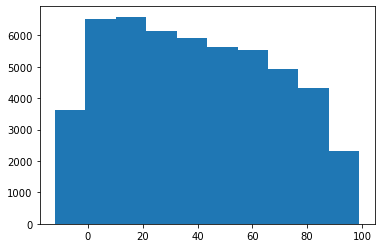

In [14]:
plt.hist([x[0] for x in spacing_x_counts[1]])
plt.show()

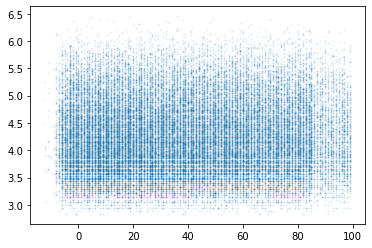

In [16]:
subset = [x for x in spacing_x_counts[0]] # if x[1]==("+","-")]
plt.scatter([x[0] for x in subset], [x[2] for x in subset], s=1, alpha=0.1)

In [352]:
np.median([x[2] for x in subset])

4.189654742026425

In [353]:
np.median([x[2] for x in subset if  x[0]>80])

4.219507705176107

In [354]:
np.median([x[2] for x in subset if  x[0]<20])

4.174387269895637

In [325]:
from scipy.stats import spearmanr

In [355]:
spearmanr([x[0] for x in subset], [x[2] for x in subset])

SpearmanrResult(correlation=0.01609498091069657, pvalue=0.00025751717534177313)

In [356]:
peak_set_intervals['chr1'][48201]

{Interval(48200, 48959, 10)}

In [328]:
subset_p8 = [x for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==8]
subset_p10 = [x for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==10]
subset_p11 = [x for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==11]
subset_p13 = [x for x in spacing_x_counts[0] if peak_set_intervals[x[3]][x[4].begin] and list(peak_set_intervals[x[3]][x[4].begin])[0].data==13]

(array([0.00635571, 0.01108709, 0.01113925, 0.01087101, 0.01009611,
        0.0096416 , 0.01001415, 0.00874748, 0.00796512, 0.00417256]),
 array([-12. ,  -0.9,  10.2,  21.3,  32.4,  43.5,  54.6,  65.7,  76.8,
         87.9,  99. ]),
 <BarContainer object of 10 artists>)

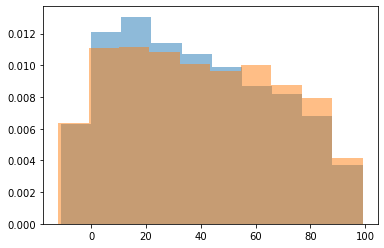

In [329]:
plt.hist(([x[0] for x in subset_p13]), density=True, alpha=0.5)
plt.hist(([x[0] for x in subset_p8]), density=True, alpha=0.5)

In [330]:
np.median([x[0] for x in subset_p13])

35.0

In [331]:
np.median([x[0] for x in subset_p11])

38.0

In [332]:
np.median([x[0] for x in subset_p10])

38.0

In [333]:
np.median([x[0] for x in subset_p8])

38.0

In [334]:
import scipy

In [361]:
print(scipy.stats.mannwhitneyu([x[0] for x in subset_p13], 
                               [x[0] for x in subset_p8])[1])

8.37716896726629e-05


In [336]:
sample(subset_p8, 5)

[(6,
  ('+', '-'),
  4.912654885736052,
  'chr8',
  Interval(115769769, 115769783, '-'),
  Interval(115769749, 115769763, '+')),
 (24,
  ('+', '+'),
  3.6109179126442243,
  'chr1',
  Interval(42272025, 42272039, '+'),
  Interval(42272063, 42272077, '+')),
 (86,
  ('-', '+'),
  4.442651256490317,
  'chr14',
  Interval(59176841, 59176855, '+'),
  Interval(59176741, 59176755, '-')),
 (42,
  ('-', '-'),
  4.77912349311153,
  'chr16',
  Interval(83297270, 83297284, '+'),
  Interval(83297214, 83297228, '+')),
 (1,
  ('-', '+'),
  4.477336814478207,
  'chr1',
  Interval(99841267, 99841281, '-'),
  Interval(99841282, 99841296, '+'))]